# Machine Learning Project1

刘书畅 518021910789

---

## 1. 概述

* 本项目实现两种分类算法：
    * Naïve Bayesian
    * Logistic Regression
* 并使用sklearn Python package实现SVM
* 比较三种分类方法的表现

## 2. 数据导入及划分
本项目使用如下的包：

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import random
from sklearn.svm import SVC

使用的数据集为Mobile Price Classification.

下载地址： https://www.kaggle.com/iabhishekofficial/mobile-price-classification?select=train.csv

导入数据：
(数据和本文件应置于相同文件夹下)

In [65]:
data=pd.read_csv("train.csv")
data.shape

(2000, 21)

数据共有2000行, 21列

In [66]:
data.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

* 本项目根据前20项数据特征, 预测第21项数据"price_range"
* "price_range"被分为两类：low(0,1) , high(2,3)
* 将‘train.csv’ 以0.8:0.1:0.1的比例随机分为‘train’ , ‘valid’ 和 ‘test’ 三份

In [67]:
train_data,valid_data,test_data = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

* 使用train_time记录三种方法的训练时间
* 使用test_result记录三种方法的分类结果分数
* 使用test_time记录三种方法的分类时间

In [68]:
train_time=[0,0,0]
test_result=np.zeros((3,3))
test_time=np.zeros((3,3))


## 2. Naïve Bayesian

### 1. 预处理
数据预处理包括:
* Convert labels into to two classes: low (0, 1) and high (2, 3)
*  data normalization
* discretize continuous attributes into intervals
* split large number into ranges [0,r)

所以定义如下类DataNB:

In [69]:
class DataNB:

    def __init__(self,string,data,r):
        self.name=string

        self.x_data=data[:,:-1]
        self.y_data=data[:,-1,np.newaxis]

        self.row,self.x_col=np.mat(self.x_data).shape

        low=np.min(self.x_data,axis=0)
        high=np.max(self.x_data,axis=0)


        for i in range(self.row):
            self.y_data[i]=math.floor(self.y_data[i]/2)
            for j in range(self.x_col):
                self.x_data[i,j]=math.floor((self.x_data[i,j]-low[j])*(r-1)/(high[j]-low[j]))

### 2. 训练

#### 1. 预处理数据
设置数据范围为[0,r)

In [70]:
r=10
train =DataNB("train",train_data.values,r)

#### 2. 训练
* 贝叶斯公式：
$$P(C_j|x_1,x_2,...,x_d) = \frac {P(x_1,x_2,...,x_d|C_j)P(C_j)}{P(x_1,x_2,...,x_d)}$$
* 因为分类时分母相同,于是只需要计算:
$$ arg{max}_{c_k}p(x_1,x_2,...,x_d|C_j)P(C_j) $$
* 因为条件独立:
$$ p(x_1,x_2,...,x_d|C_j)= \prod_{i=1}^dp(x_i|C_j) $$
* 代码实现中用变量pResult记录price_range特征low和high的出现概率 $$p(C_i)$$
* 用变量pAttribute(i,m,j)记录$$ p(x_i=m|C_j) $$


In [71]:
def train_nb(train):
    print("training begin")
    begin=time.time()
    pResult=[0,0]
    pAttribute=np.zeros(shape=( train.x_col, r,2))
    for i in range(train.row):
        pResult[int(train.y_data[i])]+=1
        for j in range(train.x_col):
            pAttribute[j][int(train.x_data[i,j])][int(train.y_data[i])]+=1

    pResult[0]=pResult[0]*(1/train.row)
    pResult[1]=pResult[1]*(1/train.row)
    pAttribute=pAttribute/train.row
    stop=time.time()-begin
    print("training time:")
    print(stop)

    return [stop,pResult,pAttribute]

train_time[0],pResult,pAttribute=train_nb(train)

training begin
training time:
0.09447407722473145


#### 3. 测试
使用valid_data,test_data数据进行测试

In [72]:
valid=DataNB("valid",valid_data.values,r)
test=DataNB("test",test_data.values,r)

$$ C_{NB} = arg{max}_{c_k}p(x_1,x_2,...,x_d|C_j)P(C_j) $$

In [73]:
def test_nb(data,pResult,pAttribute):
        print("")
        print("testing:")
        print(data.name)
        begin=time.time()
        score=0

        for i in range(data.row):
            probability=[0,0]
            for j in range(2):
                probability[j]=pResult[j]
                for k in range(data.x_col):
                    probability[j]*=pAttribute[k][int(data.x_data[i,k])][j]

            if probability[1]>probability[0] and data.y_data[i]==1:
                score+=1
            elif probability[1]<probability[0] and data.y_data[i]==0:
                score+=1
        score/=data.row
        stop=time.time()-begin
        print("time:")
        print(stop)
        print("score:")
        print(score)

        return [stop,score]

test_time[0,0],test_result[0,0]=test_nb(train,pResult,pAttribute)
test_time[0,1],test_result[0,1]=test_nb(valid,pResult,pAttribute)
test_time[0,2],test_result[0,2]=test_nb(test,pResult,pAttribute)


testing:
train
time:
0.16887116432189941
score:
0.905625

testing:
valid
time:
0.010883092880249023
score:
0.885

testing:
test
time:
0.012025833129882812
score:
0.865


## 2. Logistic Regression

### 1. 预处理数据
* 用x_data存储特征值,y_data存储price_range的值
* 将y_data的值归一到（0,1）
* 将x_data的值归一到（0,1）
* 给样本添加偏置值


In [74]:
class DataLR:
    #数据预处理
    def __init__(self,string,data):
        self.name=string

        self.x_data=data[:,:-1]
        self.y_data=data[:,-1,np.newaxis]

        self.row,self.x_col=np.mat(self.x_data).shape

        low=np.min(self.x_data,axis=0)
        high=np.max(self.x_data,axis=0)



        for i in range(self.row):
            self.y_data[i]=math.floor(self.y_data[i]/2)
            for j in range(self.x_col):
                 self.x_data[i,j]=( self.x_data[i,j]-low[j])/(high[j]-low[j])

        # 添加偏置值
        self.x_data = np.concatenate((np.ones((self.row,1)),self.x_data),axis=1)

train =DataLR("train",train_data.values)
valid= DataLR("valid",valid_data.values)

### 2. 训练
1. sigmoid函数:
   $$ sigmoid(x)=\frac {1}{1+e^{-x}} $$
2. cost函数,计算代价值:
3. 梯度下降
4. 训练时用valid数据做验证,当valid和train的cost都几乎不再改变时就认为已收敛

In [75]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

def cost(x_mat, y_mat, ws):
    left = np.multiply(y_mat, np.log(sigmoid(x_mat*ws)))
    right = np.multiply(1 - y_mat, np.log(1 - sigmoid(x_mat*ws)))
    return np.sum(left + right) / -(len(x_mat))

def train_lr(train,valid,accuracy = 0.000001):

    x_mat = np.mat(train.x_data)
    y_mat = np.mat(train.y_data)

    valid_x_mat =np.mat(valid.x_data)
    valid_y_mat=np.mat(valid.y_data)

    lr = 0.05

    # 用于画出代价函数的收敛曲线
    train_cost_list = []
    valid_cost_list = []

    # 计算数据行列数
    # 行代表数据个数，列代表权值个数
    m,n = np.shape(x_mat)
    # 初始化权值
    print("training begin")
    begin=time.time()
    ws=np.mat(np.zeros((n,1)))
    for j in range(n):
        ws[j]=random.uniform(-0.01,0.01)
    i=0

    #valid 和 train 的都几乎不再改变就行了 ( |new-old|<accuracy)
    while True:

        train_old = cost(x_mat, y_mat,ws)
        valid_old = cost(valid_x_mat,valid_y_mat,ws)

        # xMat和weights矩阵相乘
        h = sigmoid(x_mat*ws)
        # 计算误差
        ws_grad = x_mat.T*(h - y_mat)/m
        ws = ws - lr*ws_grad

        train_new = cost(x_mat, y_mat,ws)
        valid_new = cost(valid_x_mat,valid_y_mat,ws)

        if i % 50 == 0:
            train_cost_list.append(train_new)
            valid_cost_list.append(valid_new)
        i+=1

        if math.fabs(train_new - train_old) < accuracy and math.fabs(valid_new - valid_old) < accuracy:
            break

    stop=time.time()-begin
    print("training time:")
    print(stop)
    return stop,ws,train_cost_list,valid_cost_list

train_time[1],ws,train_cost_list,valid_cost_list =train_lr(train, valid,0.000001)

training begin
training time:
40.35889291763306


画出代价函数的收敛曲线

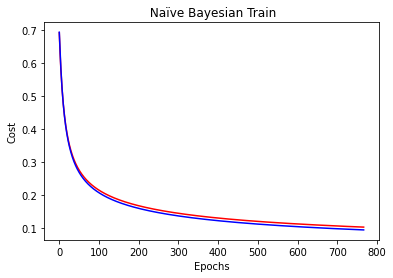

In [76]:
x = np.linspace(0,len(train_cost_list),len(train_cost_list))
plt.plot(x, train_cost_list,label='train', c='r')
plt.plot(x,valid_cost_list,label='valid',c='b')
plt.title(' Naïve Bayesian Train')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

### 3. 测试
#### 1.数据预处理

In [77]:
valid =DataLR("valid",valid_data.values)
test =DataLR("test",test_data.values)


#### 2. 测试


In [78]:
def test_lr(data,ws):
    print("")
    print(data.name)
    xMat = np.mat(data.x_data)
    ws = np.mat(ws)
    begin=time.time()
    score=0
    final=xMat*ws
    m,n=final.shape
    for i in range(m):
        if final[i]>0 and data.y_data[i]==1:
            score+=1
        elif final[i]<=0 and data.y_data[i]==0:
            score+=1
    score/=m
    stop=time.time()-begin
    print("time:")
    print(stop)
    print("score:")
    print(score)

    return stop,score

test_time[1,0],test_result[1,0]=test_lr(train,ws)
test_time[1,1],test_result[1,1]=test_lr(valid,ws)
test_time[1,2],test_result[1,2]=test_lr(test,ws)


train
time:
0.05584883689880371
score:
0.983125

valid
time:
0.00897669792175293
score:
0.995

test
time:
0.007213592529296875
score:
0.945


## 3. SVM

### 1. 数据预处理

In [79]:
class DataSVM:
    def __init__(self,string,data):
        self.name=string

        self.x_data=data[:,:-1]
        self.y_data=data[:,-1,np.newaxis]

        self.row,self.x_col=np.mat(self.x_data).shape

        # self.data=data.reset_index()
        # self.row,self.col=self.data.shape
        # self.value=self.data['price_range']
        for i in range(self.row):
            self.y_data[i]=math.floor(self.y_data[i]/2)


#数据预处理
train=DataSVM("train",train_data.values)
valid=DataSVM("valid",valid_data.values)
test=DataSVM("test",test_data.values)

### 2. 训练

In [80]:
#用train数据训练
def train_svm(train):
    print("training begin")
    begin=time.time()
    clf=SVC()
    clf.fit(train.x_data,train.y_data)
    stop=time.time()-begin
    print("training time:")
    print(stop)
    return stop,clf

train_time[2],clf=train_svm(train)

training begin
training time:
0.03723430633544922


c:\users\97537\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### 3.测试

In [81]:
#测试
def test_svm(self,clf):
    print("")
    print("testing:")
    print(self.name)
    begin=time.time()
    score=clf.score(self.x_data,self.y_data)
    stop=time.time()-begin
    print("time:")
    print(stop)
    print("score:")
    print(score)
    return stop,score
#测试
test_time[2,0],test_result[2,0]=test_svm(train,clf)
test_time[2,1],test_result[2,1]=test_svm(valid,clf)
test_time[2,2],test_result[2,2]=test_svm(test,clf)


testing:
train
time:
0.022938966751098633
score:
0.98375

testing:
valid
time:
0.004987001419067383
score:
0.995

testing:
test
time:
0.003981590270996094
score:
0.985


## 4.结果分析
### 1.训练时间
#### 1. 对比三种方法的训练时间

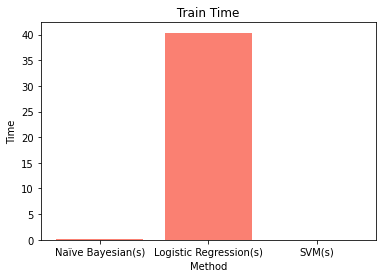

,Naïve Bayesian,Logistic Regression,SVM
0,0.094474,40.358893,0.037234


In [82]:
plt.title(' Train Time ')
plt.xlabel('Method')
plt.ylabel('Time')
name_list = ['Naïve Bayesian(s)','Logistic Regression(s)','SVM(s)']
plt.bar(range(len(train_time)), train_time,fc='salmon',tick_label=name_list)

plt.show()


df = pd.DataFrame(np.mat(train_time),columns=['Naïve Bayesian','Logistic Regression','SVM'])
df.style

#### 2. Naïve Bayesian和SVM的训练时间对比图
由于Logistic Regression的训练时间远长于其他两种分类算法,柱状图中难以观察到其他两种分类方法是训练时间,
于是单独绘制

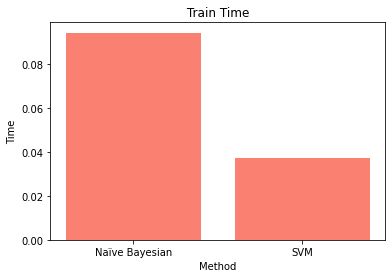

In [83]:
plt.title(' Train Time ')
plt.xlabel('Method')
plt.ylabel('Time')
name_list = ['Naïve Bayesian','SVM']
train_time1=[train_time[0],train_time[2]]
plt.bar(range(len(train_time1)), train_time1,fc='salmon',tick_label=name_list)
plt.show()

#### 3. 总结
* 训练时间:
$$ Logistic Regression> Naïve Bayesian > SVM $$
* Logistic Regression的训练时间远长于其他两种分类算法
* Logistic Regression的训练时间和精度取决于判定收敛停止循环的精度,精度越高分类准确率越高,相应训练时间也会增长
*  Naïve Bayesian ,SVM训练时间较为接近, Naïve Bayesian 略长于SVM

### 2. 测试分数
#### 1. 柱状图

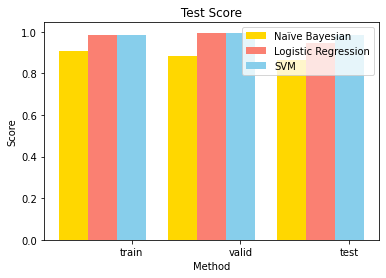

In [84]:
name_list = ['train','valid','test']
x =list(range(len(test_result[0])))
total_width, n = 0.8, 3
width = total_width / n
plt.title(' Test Score ')
plt.xlabel('Method')
plt.ylabel('Score')
plt.bar(x, test_result[0], width=width, label='Naïve Bayesian',fc = 'gold')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_result[1], width=width, label='Logistic Regression',tick_label = name_list,fc = 'salmon')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_result[2], width=width, label='SVM',tick_label = name_list,fc = 'skyblue')
plt.legend()
plt.show()

#### 2. 表格
第0行代表Naïve Bayesian,第1行代表Logistic Regression,第1行代表SVM

In [85]:
df = pd.DataFrame(np.mat(test_result),columns=['train','valid','test'])
df.style


,train,valid,test
0,0.905625,0.885000,0.865000
1,0.983125,0.995000,0.945000
2,0.983750,0.995000,0.985000


#### 3. 总结
* 分类结果分数:
$$SVM ,Logistic Regression> Naïve Bayesian $$
* Logistic Regression的训练时间和精度取决于判定收敛停止循环的精度,精度越高分类准确率越高,相应训练时间也会增长
*  在次项目设置精度下，Logistic Regression ,SVM训练分数接近, 准确率较高

### 3. 分类时间
#### 1. 柱状图

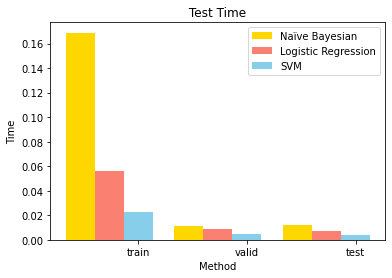

In [86]:
name_list = ['train','valid','test']
x =list(range(len(test_result[0])))
total_width, n = 0.8, 3
width = total_width / n
plt.title(' Test Time ')
plt.xlabel('Method')
plt.ylabel('Time')
plt.bar(x, test_time[0], width=width, label='Naïve Bayesian',fc = 'gold')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_time[1], width=width, label='Logistic Regression',tick_label = name_list,fc = 'salmon')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, test_time[2], width=width, label='SVM',tick_label = name_list,fc = 'skyblue')
plt.legend()
plt.show()

#### 2. 表格
第0行代表Naïve Bayesian,第1行代表Logistic Regression,第1行代表SVM

In [87]:
df = pd.DataFrame(np.mat(test_time),columns=['train','valid','test'])
df.style


,train,valid,test
0,0.168871,0.010883,0.012026
1,0.055849,0.008977,0.007214
2,0.022939,0.004987,0.003982


#### 3. 总结
* 分类时间:
$$ Naïve Bayesian>Logistic Regression>SVM   $$

*   Naïve Bayesian 远高于Logistic Regression和SVM

## 5.总结

<table>
    <tr>
        <th colspan=1>特征</th>
        <th>Naive Bayesian</th>
        <th>Logistic Regression</th>
        <th>SVM</th>
    </tr>
    <tr>
        <td >训练时间</td>
        <td>略长于SVM
        </td>
        <td>最长<br/>训练时间和准确率受收敛停止时的精度影响</td>
        <td>最短</td>
    </tr>
    <tr>
        <td >准确率</td>
        <td>最低<br/>假设属性之间相互独立,实际应用中往往是不成立</td>
        <td>和SVM相近</td>
        <td>和Logistic Regression相近</td>
    </tr>
    <tr>
        <td>分类时间</td>
        <td>最长</td>
        <td>略高于SVM</td>
        <td>最短</td>
    </tr>

</table>


### 1. Naive Bayesian
* 优点
    * 算法逻辑简单,易于实现
    * 分类过程中时空开销小,假设特征相互独立,只会涉及到二维存储
* 缺点
    * 朴素贝叶斯假设属性之间相互独立，这种假设在实际过程中往往是不成立的,导致准确率降低
    * 在属性之间相关性越大，分类误差也就越大
    * 分类时间较长

### 2. Logistic Regression
* 优点
    * 算法逻辑简单,易于实现
    * 存储资源低
* 缺点
    * 当特征空间很大时，逻辑回归的性能不是很好
    * 不能很好地处理大量多类特征或变量
    * 只能处理两分类问题
    * 训练时间较长

### 3. SVM
* 优点
    * 分类效果好
* 缺点
    * 对大规模训练样本难以实施
    * 经典的支持向量机算法只给出了二类分类的算法

### 4.朴素贝叶斯与逻辑回归的区别
<table>
    <tr>
        <th>Naive Bayesian</th>
        <th>Logistic Regression</th>
    </tr>
    <tr>
        <td >生成模型</td>
        <td>判别模型</td>
    </tr>
    <tr>
        <td >对特征x和目标y的联合分布P(x,y)建模，使用极大后验概率估计法估计出最有可能的P(y|x)</td>
        <td>直接对后验概率P(y|x)建模，使用极大似然估计法使其最大化</td>
    </tr>
    <tr>
        <td>不需要优化参数，先用极大似然估计法估计出先验概率P(y)和条件概率P(x|y)，然后计算出极大后验概率P(y|x)</td>
        <td>需要优化参数，先用极大似然估计法得出损失函数，再用梯度下降法等优化参数</td>
    </tr>
    <tr>
        <td>假设特征之间相互独立，对于不相互独立的特征，朴素贝叶斯的分类效果会差一些</td>
        <td>不必假设特征之间是相互独立的，对于不相互独立的特征，逻辑回归会在训练过程中对参数自动调整</td>
    </tr>

</table>

